# Model

While testing the loss function against the next dataloader output, it failed because of a mismatch of shapes (see bottom of [03_loss.ipynb](03_loss.ipynb)). 

There is thus a need to clarify what shape is returned by the model itself, before returning to the loss function analysis.

In [1]:
%run review/__common.py
%load_ext autoreload
%autoreload 2

[W1223 23:59:43.866129340 Utils.hpp:135] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())


## Backlog
- How is training distributed?
- What are the following for?
    - cfg.num_channels_static for?
    - cfg.concat_trick
- What is `output_dim_grid_nodes=cfg.num_channels_climate, # 73` ?

## Smoke test

The model is first initialized at [1]:

```python
from modulus.models.graphcast.graph_cast_net import GraphCastNet
...
class GraphCastTrainer(BaseTrainer):
    def __init__(self, cfg: DictConfig, dist, rank_zero_logger):
        ...
        # instantiate the model
        self.model = GraphCastNet(
            mesh_level=cfg.mesh_level,
            multimesh=cfg.multimesh,
            input_res=tuple(cfg.latlon_res),
            input_dim_grid_nodes=(
                cfg.num_channels_climate
                + cfg.use_cos_zenith
                + 4 * cfg.use_time_of_year_index
            )
            * (cfg.num_history + 1)
            + cfg.num_channels_static,
            input_dim_mesh_nodes=3,
            input_dim_edges=4,
            output_dim_grid_nodes=cfg.num_channels_climate,
            processor_type=cfg.processor_type,
            khop_neighbors=cfg.khop_neighbors,
            num_attention_heads=cfg.num_attention_heads,
            processor_layers=cfg.processor_layers,
            hidden_dim=cfg.hidden_dim,
            norm_type=cfg.norm_type,
            do_concat_trick=cfg.concat_trick,
            use_cugraphops_encoder=cfg.cugraphops_encoder,
            use_cugraphops_processor=cfg.cugraphops_processor,
            use_cugraphops_decoder=cfg.cugraphops_decoder,
            recompute_activation=cfg.recompute_activation,
        )
```

The way in which `input_dim_grid_nodes` is initialized is not immediately clear. Testing it next.

- [1] https://vscode.dev/github/NVIDIA/modulus/blob/main/examples/weather/graphcast/train_graphcast.py#L105



In [2]:
input_dim_grid_nodes = (
    cfg.num_channels_climate + 
    cfg.use_cos_zenith + 
    4 * cfg.use_time_of_year_index
) * (cfg.num_history + 1) + cfg.num_channels_static

print(f"""
Configuration values:
- cfg.num_channels_climate = {cfg.num_channels_climate}
- cfg.use_cos_zenith = {cfg.use_cos_zenith}
- cfg.use_time_of_year_index = {cfg.use_time_of_year_index}
- cfg.num_history = {cfg.num_history}
- cfg.num_channels_static = {cfg.num_channels_static}

(num_channels_climate + use_cos_zenith + 4 * use_time_of_year_index) * (num_history + 1) + num_channels_static
({cfg.num_channels_climate} + {int(cfg.use_cos_zenith)} + 4 * {int(cfg.use_time_of_year_index)}) * ({cfg.num_history} + 1) + {cfg.num_channels_static}

input_dim_grid_nodes = {input_dim_grid_nodes}
""")


Configuration values:
- cfg.num_channels_climate = 21
- cfg.use_cos_zenith = True
- cfg.use_time_of_year_index = True
- cfg.num_history = 0
- cfg.num_channels_static = 5

(num_channels_climate + use_cos_zenith + 4 * use_time_of_year_index) * (num_history + 1) + num_channels_static
(21 + 1 + 4 * 1) * (0 + 1) + 5

input_dim_grid_nodes = 31



So,
- Historical data would be stacked into the same input
- Rightfully, cos_zenith and "time of year" information are dependent on the point in time, thus they are included for each history step
- Static channels are included for each input sample.

After several attempt ending up in Out of memory errors, the configuration of the model is watered down to have a smaller memory footprint.

In [4]:
from modulus.models.graphcast.graph_cast_net import GraphCastNet

model = GraphCastNet(
    mesh_level=4, # ----- cfg.mesh_level (default: 6)
    multimesh=cfg.multimesh, # true
    input_res=tuple(cfg.latlon_res), # [721, 1440]
    input_dim_grid_nodes=input_dim_grid_nodes, # 31 in the case above
    input_dim_mesh_nodes=3,
    input_dim_edges=4,
    output_dim_grid_nodes=cfg.num_channels_climate, # 73 ---> What is this?
    processor_type=cfg.processor_type, # MessagePassing
    khop_neighbors=cfg.khop_neighbors, # 32
    num_attention_heads=cfg.num_attention_heads, # 4
    processor_layers=4, # ----- cfg.processor_layers (default: 16)
    hidden_dim=64, # ----- cfg.hidden_dim (default: 512)
    norm_type=cfg.norm_type, # TELayerNorm
    do_concat_trick=cfg.concat_trick, # true
    use_cugraphops_encoder=cfg.cugraphops_encoder, # false
    use_cugraphops_processor=cfg.cugraphops_processor, # false
    use_cugraphops_decoder=cfg.cugraphops_decoder, # false
    recompute_activation=cfg.recompute_activation, # true
)
model = model.to("cuda")

In such a reduced configuration, the model can be initialized.

The input share from [03_loss.ipynb](03_loss.ipynb) is known to be: `torch.Size([1, 31, 721, 1440]`.

The way to invoke the model is taken from [1].

- [1] https://vscode.dev/github/NVIDIA/modulus/blob/main/examples/weather/graphcast/train_base.py#L36

torch.Size([1, 31, 721, 1440])


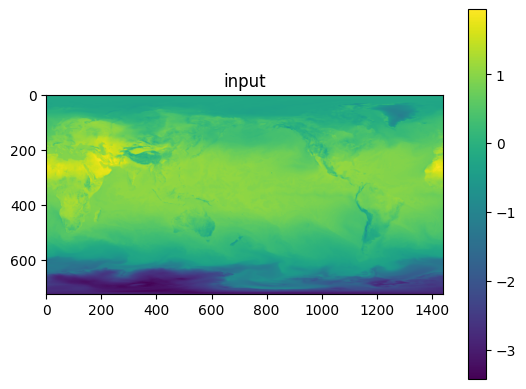

In [6]:
# # mock input
# invar_cat = torch.ones((1, 31, 721, 1440))
# print(invar_cat.dtype)

# # move to gpu
# invar_cat = invar_cat.to("cuda")

invar_cat = np.load("/mnt/data-slow/dsm/review/tmp_input.npy")
invar_cat = torch.tensor(invar_cat).to("cuda")
print(invar_cat.shape)

plt.imshow(invar_cat[0, 2].detach().cpu().numpy())
plt.colorbar()
plt.title("input")
plt.show()

torch.Size([1, 31, 721, 1440]) torch.Size([1, 21, 721, 1440])


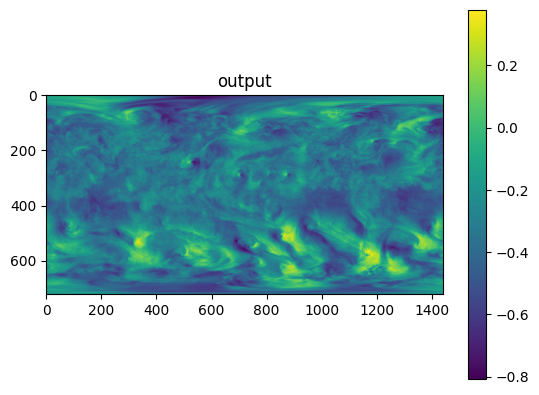

In [7]:
out = model(invar_cat)
print(invar_cat.shape, out.shape)

#plt.figure(figsize=(20, 10))
plt.imshow(out[0, 2].detach().cpu().numpy())
plt.colorbar()
plt.title("output")
plt.show()

## GraphCastNet \_\_init\_\_

Starting from the model initialization found at [1], here copied and simplified.

- [1] https://vscode.dev/github/NVIDIA/modulus/blob/main/modulus/models/graphcast/graph_cast_net.py#L240

The code anaylsis starts with the model constructor in [1]. Here is the function call. Its contents are shown in the cells that follow.

```python
class GraphCastNet(Module):
    def __init__(
        #self,
        #mesh_level: Optional[int] = 6, <--- 4
        #multimesh: bool = True, <--- True
        #input_res: tuple = (721, 1440), <--- [721, 1440]
        #input_dim_grid_nodes: int = 474, <--- 31
        #input_dim_mesh_nodes: int = 3, <--- 3
        #input_dim_edges: int = 4, <--- 4
        #output_dim_grid_nodes: int = 227, <--- 73
        #processor_type: str = "MessagePassing", <--- MessagePassing
        #khop_neighbors: int = 32, <--- 32
        #num_attention_heads: int = 4, <--- 4
        #processor_layers: int = 16, <--- 4
        hidden_layers: int = 1,
        #hidden_dim: int = 512, <--- 64
        aggregation: str = "sum",
        activation_fn: str = "silu",
        #norm_type: str = "LayerNorm", <--- TELayerNorm
        #use_cugraphops_encoder: bool = False, <--- False
        #use_cugraphops_processor: bool = False, <--- False
        #use_cugraphops_decoder: bool = False, <--- False
        #do_concat_trick: bool = False, <--- True
        #recompute_activation: bool = False, <--- True
        partition_size: int = 1,
        partition_group_name: Optional[str] = None,
        use_lat_lon_partitioning: bool = False,
        expect_partitioned_input: bool = False,
        global_features_on_rank_0: bool = False,
        produce_aggregated_output: bool = True,
        produce_aggregated_output_on_all_ranks: bool = True,
    ):
        self.g2m_edata = self.g2m_graph.edata["x"]
        self.m2g_edata = self.m2g_graph.edata["x"]
        self.mesh_ndata = self.mesh_graph.ndata["x"]
        if self.processor_type == "MessagePassing":
            self.mesh_edata = self.mesh_graph.edata["x"]
        elif self.processor_type == "GraphTransformer":
            # Dummy tensor to avoid breaking the API
            self.mesh_edata = torch.zeros((1, input_dim_edges))
        else:
            raise ValueError(f"Invalid processor type {processor_type}")

        if use_cugraphops_encoder or self.is_distributed:
            kwargs = {}
            if use_lat_lon_partitioning:
                min_seps, max_seps = get_lat_lon_partition_separators(partition_size)
                kwargs = {
                    "src_coordinates": self.g2m_graph.srcdata["lat_lon"],
                    "dst_coordinates": self.g2m_graph.dstdata["lat_lon"],
                    "coordinate_separators_min": min_seps,
                    "coordinate_separators_max": max_seps,
                }
            self.g2m_graph, edge_perm = CuGraphCSC.from_dgl(
                graph=self.g2m_graph,
                partition_size=partition_size,
                partition_group_name=partition_group_name,
                partition_by_bbox=use_lat_lon_partitioning,
                **kwargs,
            )
            self.g2m_edata = self.g2m_edata[edge_perm]

            if self.is_distributed:
                self.g2m_edata = self.g2m_graph.get_edge_features_in_partition(
                    self.g2m_edata
                )

        if use_cugraphops_decoder or self.is_distributed:
            kwargs = {}
            if use_lat_lon_partitioning:
                min_seps, max_seps = get_lat_lon_partition_separators(partition_size)
                kwargs = {
                    "src_coordinates": self.m2g_graph.srcdata["lat_lon"],
                    "dst_coordinates": self.m2g_graph.dstdata["lat_lon"],
                    "coordinate_separators_min": min_seps,
                    "coordinate_separators_max": max_seps,
                }

            self.m2g_graph, edge_perm = CuGraphCSC.from_dgl(
                graph=self.m2g_graph,
                partition_size=partition_size,
                partition_group_name=partition_group_name,
                partition_by_bbox=use_lat_lon_partitioning,
                **kwargs,
            )
            self.m2g_edata = self.m2g_edata[edge_perm]

            if self.is_distributed:
                self.m2g_edata = self.m2g_graph.get_edge_features_in_partition(
                    self.m2g_edata
                )

        if use_cugraphops_processor or self.is_distributed:
            kwargs = {}
            if use_lat_lon_partitioning:
                min_seps, max_seps = get_lat_lon_partition_separators(partition_size)
                kwargs = {
                    "src_coordinates": self.mesh_graph.ndata["lat_lon"],
                    "dst_coordinates": self.mesh_graph.ndata["lat_lon"],
                    "coordinate_separators_min": min_seps,
                    "coordinate_separators_max": max_seps,
                }

            self.mesh_graph, edge_perm = CuGraphCSC.from_dgl(
                graph=self.mesh_graph,
                partition_size=partition_size,
                partition_group_name=partition_group_name,
                partition_by_bbox=use_lat_lon_partitioning,
                **kwargs,
            )
            self.mesh_edata = self.mesh_edata[edge_perm]
            if self.is_distributed:
                self.mesh_edata = self.mesh_graph.get_edge_features_in_partition(
                    self.mesh_edata
                )
                self.mesh_ndata = self.mesh_graph.get_dst_node_features_in_partition(
                    self.mesh_ndata
                )

        self.input_dim_grid_nodes = input_dim_grid_nodes
        self.output_dim_grid_nodes = output_dim_grid_nodes
        self.input_res = input_res

        # by default: don't checkpoint at all
        self.model_checkpoint_fn = set_checkpoint_fn(False)
        self.encoder_checkpoint_fn = set_checkpoint_fn(False)
        self.decoder_checkpoint_fn = set_checkpoint_fn(False)

        # initial feature embedder
        self.encoder_embedder = GraphCastEncoderEmbedder(
            input_dim_grid_nodes=input_dim_grid_nodes,
            input_dim_mesh_nodes=input_dim_mesh_nodes,
            input_dim_edges=input_dim_edges,
            output_dim=hidden_dim,
            hidden_dim=hidden_dim,
            hidden_layers=hidden_layers,
            activation_fn=activation_fn,
            norm_type=norm_type,
            recompute_activation=recompute_activation,
        )
        self.decoder_embedder = GraphCastDecoderEmbedder(
            input_dim_edges=input_dim_edges,
            output_dim=hidden_dim,
            hidden_dim=hidden_dim,
            hidden_layers=hidden_layers,
            activation_fn=activation_fn,
            norm_type=norm_type,
            recompute_activation=recompute_activation,
        )

        # grid2mesh encoder
        self.encoder = MeshGraphEncoder(
            aggregation=aggregation,
            input_dim_src_nodes=hidden_dim,
            input_dim_dst_nodes=hidden_dim,
            input_dim_edges=hidden_dim,
            output_dim_src_nodes=hidden_dim,
            output_dim_dst_nodes=hidden_dim,
            output_dim_edges=hidden_dim,
            hidden_dim=hidden_dim,
            hidden_layers=hidden_layers,
            activation_fn=activation_fn,
            norm_type=norm_type,
            do_concat_trick=do_concat_trick,
            recompute_activation=recompute_activation,
        )

        # icosahedron processor
        if processor_layers <= 2:
            raise ValueError("Expected at least 3 processor layers")
        if processor_type == "MessagePassing":
            self.processor_encoder = GraphCastProcessor(
                aggregation=aggregation,
                processor_layers=1,
                input_dim_nodes=hidden_dim,
                input_dim_edges=hidden_dim,
                hidden_dim=hidden_dim,
                hidden_layers=hidden_layers,
                activation_fn=activation_fn,
                norm_type=norm_type,
                do_concat_trick=do_concat_trick,
                recompute_activation=recompute_activation,
            )
            self.processor = GraphCastProcessor(
                aggregation=aggregation,
                processor_layers=processor_layers - 2,
                input_dim_nodes=hidden_dim,
                input_dim_edges=hidden_dim,
                hidden_dim=hidden_dim,
                hidden_layers=hidden_layers,
                activation_fn=activation_fn,
                norm_type=norm_type,
                do_concat_trick=do_concat_trick,
                recompute_activation=recompute_activation,
            )
            self.processor_decoder = GraphCastProcessor(
                aggregation=aggregation,
                processor_layers=1,
                input_dim_nodes=hidden_dim,
                input_dim_edges=hidden_dim,
                hidden_dim=hidden_dim,
                hidden_layers=hidden_layers,
                activation_fn=activation_fn,
                norm_type=norm_type,
                do_concat_trick=do_concat_trick,
                recompute_activation=recompute_activation,
            )
        else:
            self.processor_encoder = torch.nn.Identity()
            self.processor = GraphCastProcessorGraphTransformer(
                attention_mask=self.attn_mask,
                num_attention_heads=num_attention_heads,
                processor_layers=processor_layers,
                input_dim_nodes=hidden_dim,
                hidden_dim=hidden_dim,
            )
            self.processor_decoder = torch.nn.Identity()

        # mesh2grid decoder
        self.decoder = MeshGraphDecoder(
            aggregation=aggregation,
            input_dim_src_nodes=hidden_dim,
            input_dim_dst_nodes=hidden_dim,
            input_dim_edges=hidden_dim,
            output_dim_dst_nodes=hidden_dim,
            output_dim_edges=hidden_dim,
            hidden_dim=hidden_dim,
            hidden_layers=hidden_layers,
            activation_fn=activation_fn,
            norm_type=norm_type,
            do_concat_trick=do_concat_trick,
            recompute_activation=recompute_activation,
        )

        # final MLP
        self.finale = MeshGraphMLP(
            input_dim=hidden_dim,
            output_dim=output_dim_grid_nodes,
            hidden_dim=hidden_dim,
            hidden_layers=hidden_layers,
            activation_fn=activation_fn,
            norm_type=None,
            recompute_activation=recompute_activation,
        )
```

- [1] https://vscode.dev/github/NVIDIA/modulus/blob/main/modulus/models/graphcast/graph_cast_net.py#L240

In [3]:
# Setting the __init__ parameters

mesh_level: int = 4 # default: 6
multimesh: bool = True
input_res: tuple = (721, 1440)
input_dim_grid_nodes: int = 31 # default: 474
input_dim_mesh_nodes: int = 3
input_dim_edges: int = 4
output_dim_grid_nodes: int = 73 # default: 227
processor_type: str = "MessagePassing"
khop_neighbors: int = 32
num_attention_heads: int = 4
processor_layers: int = 4 # default: 16
hidden_dim: int = 64 # default: 512
norm_type: str = "TELayerNorm" # default: "LayerNorm"
use_cugraphops_encoder: bool = False
use_cugraphops_processor: bool = False
use_cugraphops_decoder: bool = False
do_concat_trick: bool = True # default: False
recompute_activation: bool = True # dafault: False

hidden_layers: int = 1
aggregation: str = "sum"
activation_fn: str = "silu"
partition_size: int = 1
partition_group_name: str = None
use_lat_lon_partitioning: bool = False
expect_partitioned_input: bool = False
global_features_on_rank_0: bool = False
produce_aggregated_output: bool = True
produce_aggregated_output_on_all_ranks: bool = True

Part of the init body:

In [5]:
#self.processor_type = processor_type
if processor_type == "MessagePassing":
    khop_neighbors = 0

is_distributed = False

if partition_size > 1:
    is_distributed = True

expect_partitioned_input = expect_partitioned_input # False
global_features_on_rank_0 = global_features_on_rank_0 # False
produce_aggregated_output = produce_aggregated_output # True
produce_aggregated_output_on_all_ranks = (produce_aggregated_output_on_all_ranks) # True?
partition_group_name = partition_group_name # None

# create the lat_lon_grid
latitudes = torch.linspace(-90, 90, steps=input_res[0])
longitudes = torch.linspace(-180, 180, steps=input_res[1] + 1)[1:]
lat_lon_grid = torch.stack(
    torch.meshgrid(latitudes, longitudes, indexing="ij"), dim=-1
)

from modulus.models.layers import get_activation
activation_fn = get_activation(activation_fn)

lat_lon_grid.shape, lat_lon_grid[15, 15], activation_fn

(torch.Size([721, 1440, 2]), tensor([ -86.2500, -176.0000]), SiLU())

Reviewing contents

In [6]:
lat_lon_grid, mesh_level, multimesh, khop_neighbors

(tensor([[[ -90.0000, -179.7500],
          [ -90.0000, -179.5000],
          [ -90.0000, -179.2500],
          ...,
          [ -90.0000,  179.5000],
          [ -90.0000,  179.7500],
          [ -90.0000,  180.0000]],
 
         [[ -89.7500, -179.7500],
          [ -89.7500, -179.5000],
          [ -89.7500, -179.2500],
          ...,
          [ -89.7500,  179.5000],
          [ -89.7500,  179.7500],
          [ -89.7500,  180.0000]],
 
         [[ -89.5000, -179.7500],
          [ -89.5000, -179.5000],
          [ -89.5000, -179.2500],
          ...,
          [ -89.5000,  179.5000],
          [ -89.5000,  179.7500],
          [ -89.5000,  180.0000]],
 
         ...,
 
         [[  89.5000, -179.7500],
          [  89.5000, -179.5000],
          [  89.5000, -179.2500],
          ...,
          [  89.5000,  179.5000],
          [  89.5000,  179.7500],
          [  89.5000,  180.0000]],
 
         [[  89.7500, -179.7500],
          [  89.7500, -179.5000],
          [  89.7500, -179.2

In [7]:
from modulus.utils.graphcast.graph import Graph
graph = Graph(lat_lon_grid, mesh_level, multimesh, khop_neighbors)
graph

In [15]:
mesh_graph, attn_mask = graph.create_mesh_graph(verbose=True)
mesh_graph, attn_mask

mesh graph: Graph(num_nodes=2562, num_edges=20460,
      ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32), 'lat_lon': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'x': Scheme(shape=(4,), dtype=torch.float32)})


(Graph(num_nodes=2562, num_edges=20460,
       ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32), 'lat_lon': Scheme(shape=(2,), dtype=torch.float32)}
       edata_schemes={'x': Scheme(shape=(4,), dtype=torch.float32)}),
 None)

In [16]:
g2m_graph = graph.create_g2m_graph(verbose=True)
g2m_graph

g2m graph: Graph(num_nodes={'grid': 1038240, 'mesh': 2562},
      num_edges={('grid', 'g2m', 'mesh'): 1618260},
      metagraph=[('grid', 'mesh', 'g2m')])


Graph(num_nodes={'grid': 1038240, 'mesh': 2562},
      num_edges={('grid', 'g2m', 'mesh'): 1618260},
      metagraph=[('grid', 'mesh', 'g2m')])

In [17]:
m2g_graph = graph.create_m2g_graph(verbose=True)
m2g_graph


m2g graph: Graph(num_nodes={'grid': 1038240, 'mesh': 2562},
      num_edges={('mesh', 'm2g', 'grid'): 3114720},
      metagraph=[('mesh', 'grid', 'm2g')])


Graph(num_nodes={'grid': 1038240, 'mesh': 2562},
      num_edges={('mesh', 'm2g', 'grid'): 3114720},
      metagraph=[('mesh', 'grid', 'm2g')])